In [1]:
#Bibliotecas
import astropy.io.fits as fits
import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import simple_norm
import time
from scipy.ndimage import zoom, gaussian_filter
import random
from sklearn.model_selection import train_test_split
from scipy.ndimage import rotate
from numpy.random import choice
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.activations import elu
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers
import time
import tensorflow as tf
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, brier_score_loss, classification_report
from matplotlib.colors import LogNorm
import seaborn as sns
from tensorflow import keras

In [2]:
start_time = time.time()
datafile_path = r"C:\Users\Cliente\Documents\TCC NATALI\hlsp_deepmerge_hst_acs-wfc3_illustris-z2_f814w-f160w_v1_sim-pristine.fits"

hdulist = fits.open(datafile_path)
header = hdulist[0].header

X = np.array(hdulist[0].data)
Y = np.array(hdulist[1].data)

t_file_read = time.time()-start_time
print("tempo para ler dados do arquivo: {:0.3f} s".format(t_file_read))

shape_hdu0 = X.data.shape
shape_hdu1 = Y.shape
print(f"Shape do HDU0 (Images): {shape_hdu0}")
print(f"Shape do HDU1 (Label): {shape_hdu1}")

tempo para ler dados do arquivo: 1.886 s
Shape do HDU0 (Images): (15426, 2, 75, 75)
Shape do HDU1 (Label): (15426,)



Exemplo de imagens por filtros:

[11604  6546]



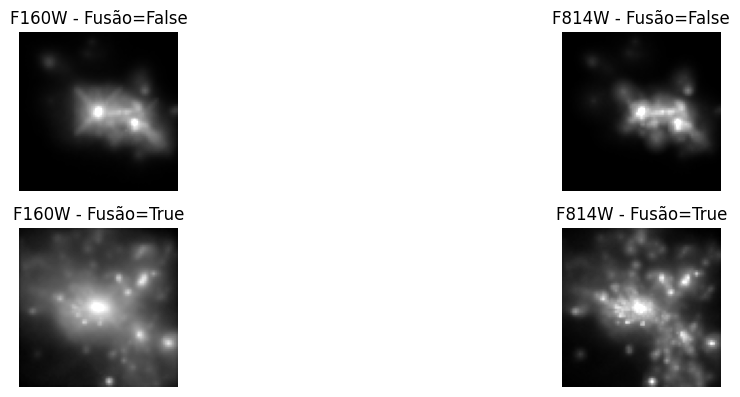

In [3]:
plot_sample_images = True
np.random.seed(206265)

examples_f160w = [hdulist[0].data[j, 1, :, :] for j in range(shape_hdu0[0])]
examples_f814w = [hdulist[0].data[j, 0, :, :] for j in range(shape_hdu0[0])]

if plot_sample_images:
    example_ids = np.random.choice(len(hdulist[0].data), 2)  # Seleciona 4 IDs aleatórios
    print("\nExemplo de imagens por filtros:\n")
    print(f'{example_ids}\n')

    # F160W filtro  no infravermelho próximo a luz visível ~ 840 nm (NIR)
    # F814W filtro no infravermelho ~ 1600nm  (FIR)

    fig = plt.figure(figsize=(11, 8))

    # Criando um loop para mostrar cada imagem com o respectivo rótulo
    for i, example_id in enumerate(example_ids):
        # F160W
        ax1 = fig.add_subplot(4, 2, (i * 2) + 1)  # Use (i * 2) + 1 como índice
        norm1 = simple_norm(hdulist[0].data[example_id, 1, :, :], 'log', max_percent=99.75)  # Acessa imagem correta
        ax1.imshow(hdulist[0].data[example_id, 1, :, :], aspect='equal', cmap='gray', norm=norm1)
        ax1.set_title('F160W - Fusão=' + str(bool(Y[example_id])))  # Usa o rótulo correto
        ax1.axis('off')

        # F814W
        ax2 = fig.add_subplot(4, 2, (i * 2) + 2)  # Use (i * 2) + 2 como índice
        norm2 = simple_norm(hdulist[0].data[example_id, 0, :, :], 'log', max_percent=99.75)  # Acessa imagem correta
        ax2.imshow(hdulist[0].data[example_id, 0, :, :], aspect='equal', cmap='gray', norm=norm2)
        ax2.set_title('F814W - Fusão=' + str(bool(Y[example_id])))  # Usa o rótulo correto
        ax2.axis('off')

    plt.tight_layout()
    plt.show()

In [4]:
data_hdu1_vec = np.array([y[0] for y in Y])
list_of_mergers = np.where(data_hdu1_vec == 1.)[0]
list_of_nonmergers = np.where(data_hdu1_vec == 0.)[0]

print(f"Shape de list_of_mergers (label = 1): {list_of_mergers.shape}")
print(f"Shape de list_of_nonmergers (label = 0): {list_of_nonmergers.shape}")

Shape de list_of_mergers (label = 1): (8120,)
Shape de list_of_nonmergers (label = 0): (7306,)


In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Define the proportions:
train_ratio = 0.7
validation_ratio = 0.1
test_ratio = 0.2

# Round the sum to ensure it equals 1.0
rounded_sum = round(train_ratio + validation_ratio + test_ratio, 10)  # Adjust decimal places as needed
assert rounded_sum == 1.0

# Divide os dados em treino e (teste + validação)
X_train, X_temp, Y_train, Y_temp = train_test_split(
    X, Y, test_size=(validation_ratio + test_ratio), random_state=42, shuffle=True, stratify=Y
)

# Divide o conjunto temporário em teste e validação
X_validation, X_test, Y_validation, Y_test = train_test_split(
    X_temp, Y_temp, test_size=test_ratio / (validation_ratio + test_ratio), random_state=42, shuffle=True, stratify=Y_temp
)

print("Tamanho do conjunto de treinamento:", X_train.shape[0])
print("Tamanho do conjunto de validação:", X_validation.shape[0])
print("Tamanho do conjunto de teste:", X_test.shape[0])

Tamanho do conjunto de treinamento: 10798
Tamanho do conjunto de validação: 1542
Tamanho do conjunto de teste: 3086


In [6]:
#Calcula a média e o desvio padrão do conjunto de treinamento.
#Normaliza os dados de treinamento, validação e teste utilizando a média e o desvio padrão do conjunto de treinamento.
mean_train = np.mean(X_train)
std_train = np.std(X_train)

X_train = (X_train - mean_train) / std_train
X_validation = (X_validation - mean_train) / std_train
X_test = (X_test - mean_train) / std_train

In [7]:
#Arquitetura da rede

t_NN_creation = time.time()

# Arquitetura da Rede (com as melhorias)
input_shape = (2, 75, 75) 

input_tensor = layers.Input(shape=input_shape)

x = layers.Conv2D(32, (5, 5), activation=elu, strides=(1, 1), padding='same', data_format='channels_first')(input_tensor)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format='channels_first')(x) 
x = layers.Dropout(0.4)(x) 

x = layers.Conv2D(64, (3, 3), activation=elu, strides=(1, 1), padding='same', data_format='channels_first')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format='channels_first')(x)
x = layers.Dropout(0.4)(x) 

x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.05))(x) 
x = layers.Dropout(0.4)(x)
x = layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.05))(x) 
x = layers.Dropout(0.4)(x)

output_tensor = layers.Dense(1, activation='sigmoid')(x)

model = keras.Model(inputs=input_tensor, outputs=output_tensor)

# Compilação do Modelo
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
metrics = ['accuracy']
loss = 'binary_crossentropy'

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

print(model.summary())

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 2, 75, 75)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 32, 75, 75)          │           1,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32, 75, 75)          │             300 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 32, 37, 37)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32, 37, 37)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 37, 37)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64, 37, 37)          │             148 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 64, 18, 18)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64, 18, 18)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 20736)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       2,654,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,679,073 (10.22 MB)

 Trainable params: 2,678,849 (10.22 MB)

 Non-trainable params: 224 (896.00 B)

None


In [8]:
checkpoint_filepath = 'melhor_modelo_pesos.weights.keras'

checkpoint = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    verbose=1,
    save_best_only=True
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    mode='min',
    verbose=1,
    patience=10,
    restore_best_weights=True
)

callbacks = [checkpoint, early_stopping]

In [9]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
metrics = ['accuracy']
loss = 'binary_crossentropy'

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

epoch = 100
batch_size = 128
shuffle = True

X_train = np.asarray(X_train).astype('float32')
X_test = np.asarray(X_test).astype('float32')
Y_train = np.asarray(Y_train).astype('float32')
Y_test = np.asarray(Y_test).astype('float32')
X_validation = np.asarray(X_validation).astype('float32')
Y_validation = np.asarray(Y_validation).astype('float32')

In [10]:
training_time = time.time()

history = model.fit(
    x=X_train,
    y=Y_train,
    batch_size=batch_size,
    epochs=epoch,
    validation_data=(X_validation, Y_validation),
    shuffle=shuffle,
    verbose=1,
    callbacks=callbacks
)

training_time =  time.time()-training_time
print("tempo para treinamento da rede: {:0.3f} s".format(training_time))

tempo_total = time.time() - start_time
print("tempo total: {:0.3f} s".format(tempo_total))

accuracy = model.evaluate(X_test, Y_test, verbose=0)[1]
print(f"Acurácia do modelo carregado: {accuracy * 100:.2f}%")

Epoch 1/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5264 - loss: 14.5477
Epoch 1: val_accuracy improved from -inf to 0.52594, saving model to melhor_modelo_pesos.weights.keras
85/85 ━━━━━━━━━━━━━━━━━━━━ 94s 1s/step - accuracy: 0.5265 - loss: 14.5305 - val_accuracy: 0.5259 - val_loss: 10.4051
Epoch 2/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5321 - loss: 9.6633
Epoch 2: val_accuracy improved from 0.52594 to 0.53307, saving model to melhor_modelo_pesos.weights.keras
85/85 ━━━━━━━━━━━━━━━━━━━━ 90s 1s/step - accuracy: 0.5322 - loss: 9.6549 - val_accuracy: 0.5331 - val_loss: 7.5708
Epoch 3/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5316 - loss: 7.1565
Epoch 3: val_accuracy improved from 0.53307 to 0.63359, saving model to melhor_modelo_pesos.weights.keras
85/85 ━━━━━━━━━━━━━━━━━━━━ 90s 1s/step - accuracy: 0.5316 - loss: 7.1517 - val_accuracy: 0.6336 - val_loss: 5.9140
Epoch 4/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5416 - loss: 5.6587
E

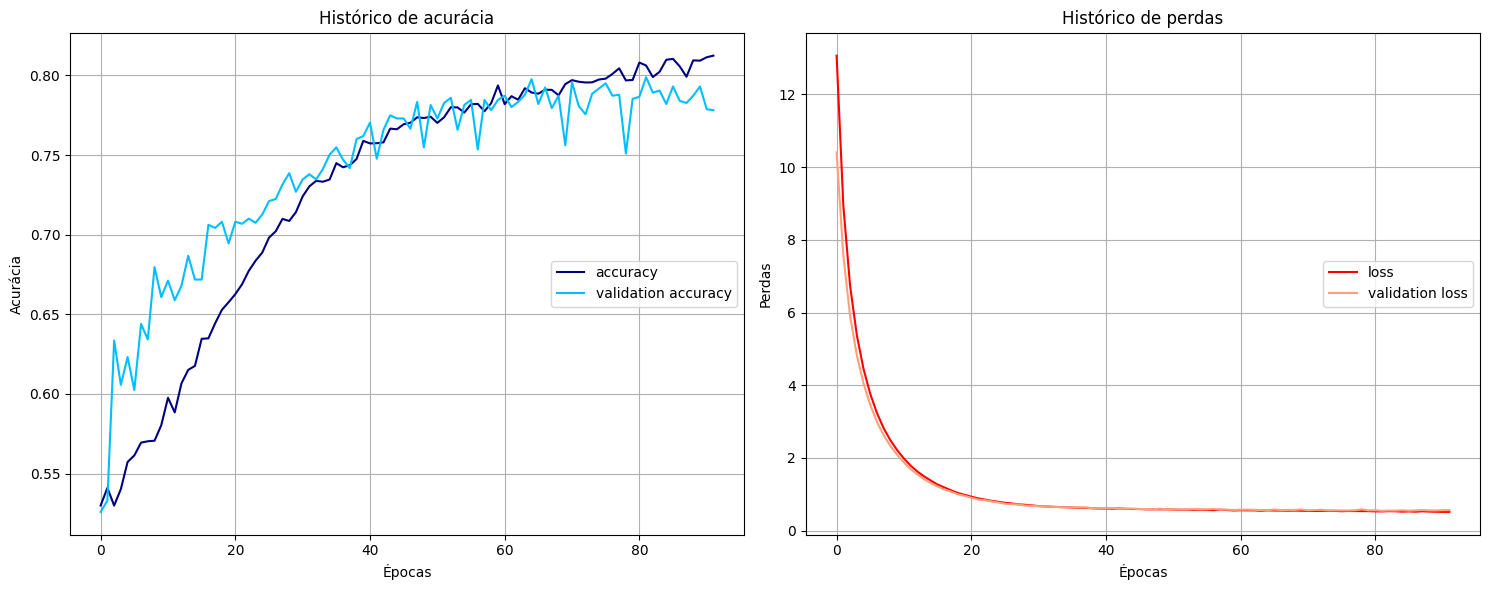

In [11]:
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = list(range(len(loss)))
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

axis1 = axs[0]
axis2 = axs[1]

axis1.plot(epochs, acc, 'navy', label='accuracy')
axis1.plot(epochs, val_acc, 'deepskyblue', label="validation accuracy")

axis2.plot(epochs, loss, 'red', label='loss')
axis2.plot(epochs, val_loss, 'lightsalmon', label="validation loss")

axis1.set_xlabel('Épocas')
axis1.set_ylabel('Acurácia')
axis1.legend(loc='center right')
axis1.grid(True)

axis2.set_xlabel('Épocas')
axis2.set_ylabel('Perdas')
axis2.legend(loc='center right')
axis2.grid(True)

axis1.set_title("Histórico de acurácia")
axis2.set_title("Histórico de perdas")

plt.tight_layout()
plt.show()

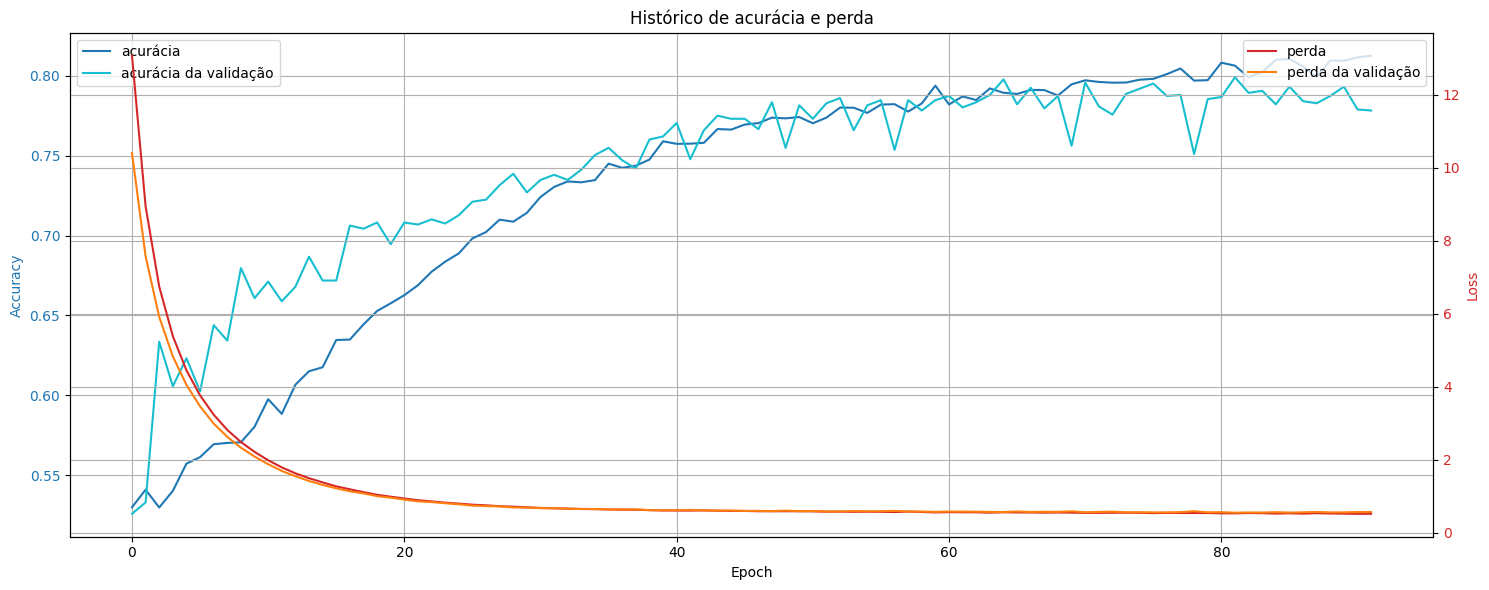

In [12]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = list(range(len(loss)))

fig, ax1 = plt.subplots(figsize=(15, 6))

# Accuracy and Validation Accuracy (left y-axis)
color = 'tab:blue'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy', color=color)
ax1.plot(epochs, acc, color=color, label='acurácia')
ax1.plot(epochs, val_acc, color='tab:cyan', label="acurácia da validação")
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc='upper left')
ax1.grid(True)

# Loss and Validation Loss (right y-axis)
ax2 = ax1.twinx()  # Create a twin axis
color = 'tab:red'
ax2.set_ylabel('Loss', color=color)
ax2.plot(epochs, loss, color=color, label='perda')
ax2.plot(epochs, val_loss, color='tab:orange', label="perda da validação")
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc='upper right')
ax2.grid(True)

plt.title("Histórico de acurácia e perda")
plt.tight_layout()
plt.show()

In [13]:
loss, accuracy = model.evaluate(X_test, Y_test, verbose=0)
print('Acurácia no conjunto de teste:', accuracy)
print('Perda no conjunto de teste:', loss)

Acurácia no conjunto de teste: 0.7935839295387268
Perda no conjunto de teste: 0.5517728328704834


97/97 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step
cm [[1157.  305.]
 [ 332. 1292.]]
cm_norm [[0.79138167 0.20861833]
 [0.2044335  0.7955665 ]]
AUC: 0.8738305967936493


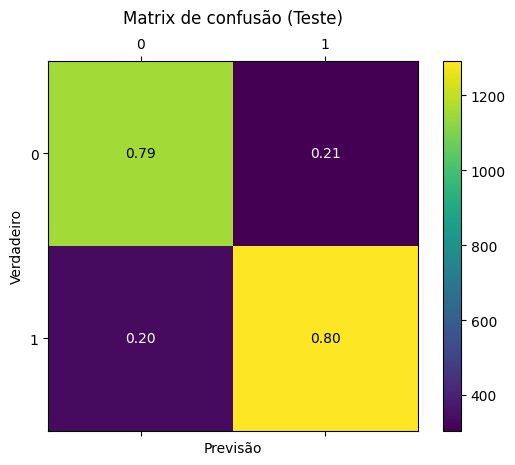

In [14]:
# ------------------------------------------------------------------------------
# Evaluate for TEST SET  ---> REPLICAR
# ------------------------------------------------------------------------------

from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

# predict
history_data = history
prob = model.predict(X_test)
pred =  (prob > 0.5).astype('int32') 

# measure confusion
labels=[0, 1]
cm = confusion_matrix(Y_test, pred, labels=labels)
cm = cm.astype('float')
cm_norm = cm / cm.sum(axis=1)[:, np.newaxis]
print("cm", cm)
print("cm_norm", cm_norm)

# Corrigindo a importação
fpr, tpr, thresholds = roc_curve(Y_test, prob, pos_label=1)
auc = roc_auc_score(Y_test, prob)
print("AUC:", auc)

#plotting
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Matrix de confusão (Teste)', y=1.08)
fig.colorbar(cax)

# Definir ticks antes de definir os rótulos
ax.set_xticks(range(len(labels)))  # Definir ticks para o eixo x
ax.set_yticks(range(len(labels)))  # Definir ticks para o eixo y

# Definir rótulos dos ticks
ax.set_xticklabels(labels)  # Remova o rótulo extra
ax.set_yticklabels(labels)

plt.xlabel('Previsão')
plt.ylabel('Verdadeiro')
fmt = '.2f'
thresh = cm_norm.max() / 2.
for i in range(cm_norm.shape[0]):
    for j in range(cm_norm.shape[1]):
        ax.text(j, i, format(cm_norm[i, j], fmt),
        ha="center", va="center",
        color="white" if cm_norm[i, j] < thresh else "black")
plt.show()

97/97 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step


Text(792.3131313131312, 0.5, 'Verdadeiro')

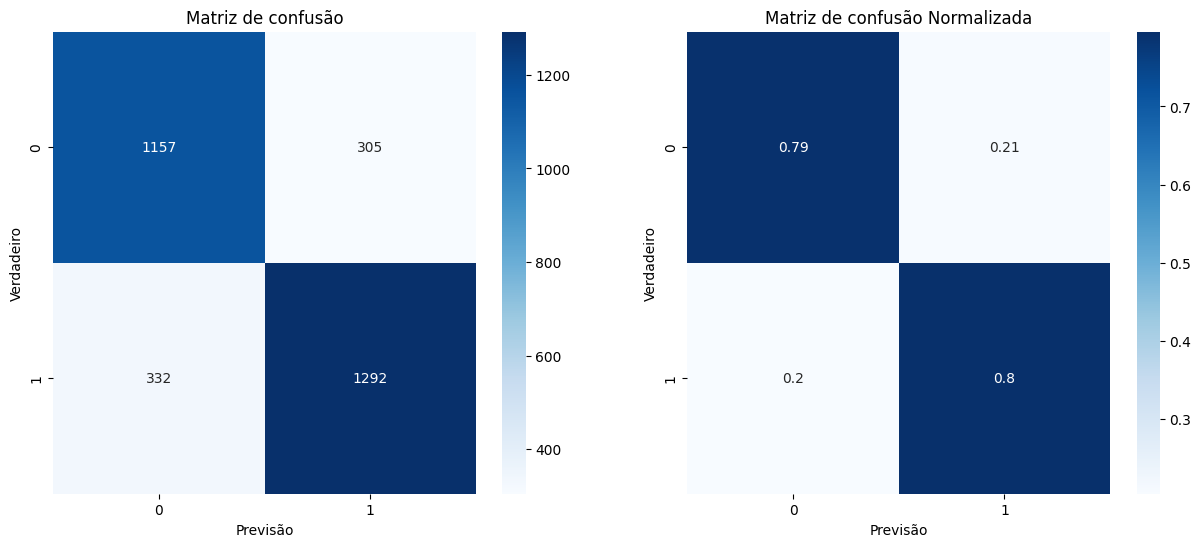

In [15]:
history_data = history
prob = model.predict(X_test)
pred =  (prob > 0.5).astype('int32')

labels=[0, 1]
cm = confusion_matrix(Y_test, pred[:,0], labels=labels)
cm_norm = cm.astype(float) / cm.astype(float).sum(axis=1)[:, np.newaxis]

fig, axs = plt.subplots(1, 2, figsize=(15, 6))

sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', ax=axs[0])
axs[0].set_title('Matriz de confusão')
axs[0].set_xlabel('Previsão')
axs[0].set_ylabel('Verdadeiro')

sns.heatmap(cm_norm, annot=True, cmap='Blues', ax=axs[1])
axs[1].set_title('Matriz de confusão Normalizada')
axs[1].set_xlabel('Previsão')
axs[1].set_ylabel('Verdadeiro')

In [16]:
#Parametros ---> REPLICAR

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(Y_test, pred)
print('Accuracy: %f' % accuracy)

# precision tp / (tp + fp)
precision = precision_score(Y_test, pred)
print('Precision: %f' % precision)

# recall: tp / (tp + fn)
recall = recall_score(Y_test, pred)
print('Recall: %f' % recall)

# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(Y_test, pred)
print('F1 score: %f' % f1)

# brier score
bs = brier_score_loss(Y_test, prob)
print('Brier score: %f' % bs)

Accuracy: 0.793584
Precision: 0.809017
Recall: 0.795567
F1 score: 0.802235
Brier score: 0.144212



 AUC: 0.8738305967936493


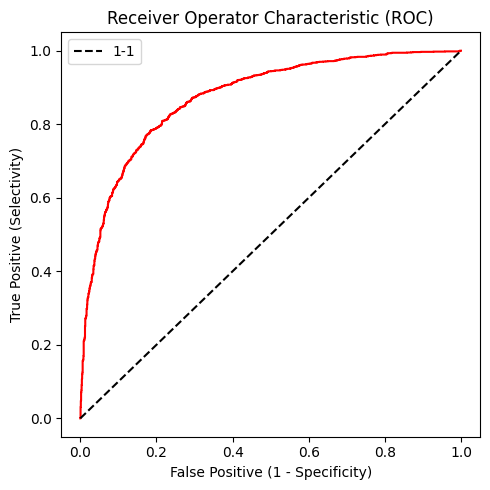

In [17]:
fpr, tpr, thresholds = roc_curve(Y_test, prob, pos_label=1)
auc = roc_auc_score(Y_test, prob)
print("\n AUC:", auc)

figsize=(5,5)
fig, axis1 = plt.subplots(figsize=figsize)
x_onetoone = y_onetoone = [0, 1]
plt.plot(fpr, tpr, 'r-')
plt.plot(x_onetoone, y_onetoone, 'k--',  label="1-1")
plt.legend(loc=0)
plt.title("Receiver Operator Characteristic (ROC)")
plt.xlabel("False Positive (1 - Specificity)")
plt.ylabel("True Positive (Selectivity)")
plt.tight_layout() 

In [18]:
bs = brier_score_loss(Y_test, prob)
print('Brier score: %f' % bs)

print('\n', classification_report(Y_test, pred))

Brier score: 0.144212

               precision    recall  f1-score   support

         0.0       0.78      0.79      0.78      1462
         1.0       0.81      0.80      0.80      1624

    accuracy                           0.79      3086
   macro avg       0.79      0.79      0.79      3086
weighted avg       0.79      0.79      0.79      3086



In [19]:
import numpy as np
import matplotlib.pyplot as plt
import random
from matplotlib.colors import LogNorm

# Fazer previsões e calcular o erro
prob = model.predict(X_test)
pred = (prob > 0.5).astype("int32")
Pred_error = pred[:, 0] - Y_test

# Calcular o número de exemplos em cada categoria
Number_of_false_negatives = np.sum(Pred_error == 1)
Number_of_false_positives = np.sum(Pred_error == -1)
Number_of_true_negatives = np.sum((Y_test + pred[:, 0]) == 0)
Number_of_true_positives = np.sum((Y_test + pred[:, 0]) == 2)

# Criar listas para armazenar os exemplos
FN = []
FP = []
TN = []
TP = []

# Preencher as listas com os exemplos
for i in range(N_test):
    if Pred_error[i] == 1:
        FN.append(X_test[i])  
    if Pred_error[i] == -1:
        FP.append(X_test[i])
    if (Y_test[i] + pred[i, 0]) == 0:
        TN.append(X_test[i])
    if (Y_test[i] + pred[i, 0]) == 2:
        TP.append(X_test[i])

print(
    f"Número de FN, FP, TN, TP = {len(FN)}, {len(FP)}, {len(TN)}, {len(TP)}",
    end=" ",
)
print(
    "({:.1f}%, {:.1f}%, {:.1f}%, {:.1f}%)".format(
        100 * len(FN) / N_test,
        100 * len(FP) / N_test,
        100 * len(TN) / N_test,
        100 * len(TP) / N_test,
    )
)

# Calcular os índices das imagens para cada categoria
TP_indices = np.where((Y_test + pred[:, 0]) == 2)[0]
FP_indices = np.where(Pred_error == -1)[0]
TN_indices = np.where((Y_test + pred[:, 0]) == 0)[0]
FN_indices = np.where(Pred_error == 1)[0]

97/97 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step


NameError: name 'N_test' is not defined

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
from matplotlib.colors import LogNorm

# Calcular os índices das imagens para cada categoria
TP_indices = np.where((Y_test + pred[:, 0]) == 2)[0]
FP_indices = np.where(Pred_error == -1)[0]
TN_indices = np.where((Y_test + pred[:, 0]) == 0)[0]
FN_indices = np.where(Pred_error == 1)[0]

# Pegar uma imagem de cada classificação e exibi-la com o colormap viridis
plt.figure(figsize=(10, 5))
plt.subplot(1, 4, 1)
plt.imshow(X_test[TP_indices[random.randint(0, len(TP_indices - 1))]], cmap="viridis")
plt.title(f"Verdadeiro Positivo\nÍndice: {TP_indices[random.randint(0, len(TP_indices - 1))]}")

plt.subplot(1, 4, 2)
plt.imshow(X_test[FP_indices[random.randint(0, len(FP_indices - 1))]], cmap="viridis")
plt.title(f"Falso Positivo\nÍndice: {FP_indices[random.randint(0, len(FP_indices - 1))]}")

plt.subplot(1, 4, 3)
plt.imshow(X_test[TN_indices[random.randint(0, len(TN_indices - 1))]], cmap="viridis")
plt.title(f"Verdadeiro Negativo\nÍndice: {TN_indices[random.randint(0, len(TN_indices - 1))]}")

plt.subplot(1, 4, 4)
plt.imshow(X_test[FN_indices[random.randint(0, len(FN_indices - 1))]], cmap="viridis")
plt.title(f"Falso Negativo\nÍndice: {FN_indices[random.randint(0, len(FN_indices - 1))]}")

plt.show()